# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.042875,True,5.993663
1,1.194247,True,6.010046
2,-0.360612,False,1.077121
3,-0.408782,False,-1.348006
4,0.182474,False,0.330399
...,...,...,...
995,0.113291,False,0.599060
996,-1.837751,False,-0.843420
997,-0.262475,True,5.646766
998,0.531213,True,4.477897


<AxesSubplot: xlabel='v0'>

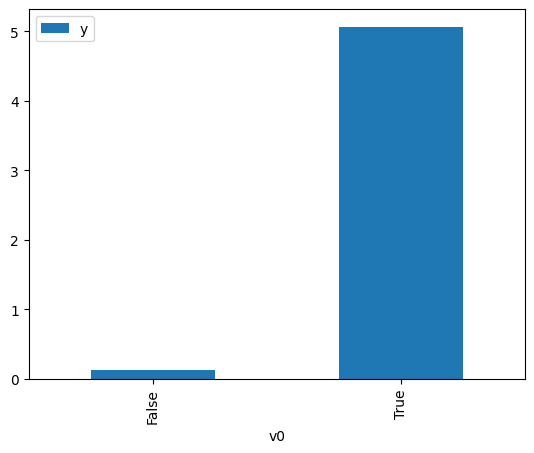

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

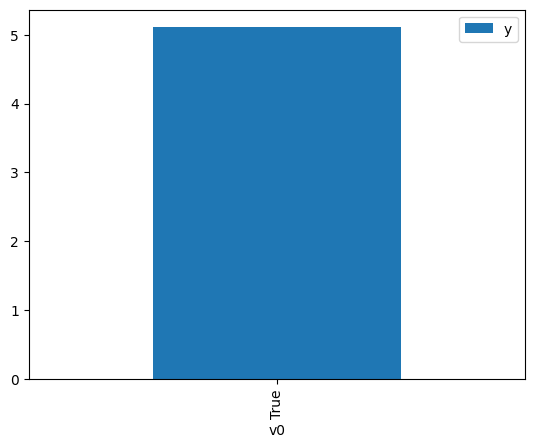

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.194322,False,1.696410,0.398784,2.507623
1,2.090521,False,5.583034,0.027205,36.757799
2,-0.783734,False,-0.066315,0.772521,1.294463
3,-0.026846,False,-0.038221,0.489693,2.042094
4,-0.360025,False,-0.120628,0.626002,1.597440
...,...,...,...,...,...
995,-0.744784,False,-1.681380,0.760890,1.314250
996,-0.160477,False,0.646751,0.545351,1.833683
997,1.109014,False,2.205334,0.125882,7.943925
998,0.834040,False,1.112179,0.185621,5.387332


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.246041,True,5.731338,0.419513,2.383719
1,-0.902804,True,3.254270,0.194438,5.143015
2,0.700007,True,6.306237,0.778150,1.285100
3,1.723720,True,5.183097,0.950935,1.051597
4,0.472034,True,6.602181,0.705630,1.417174
...,...,...,...,...,...
995,-0.569535,True,3.394226,0.296309,3.374860
996,0.334803,True,5.457685,0.655907,1.524606
997,-0.421382,True,5.232371,0.350338,2.854390
998,-0.948877,True,4.412928,0.182671,5.474328


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8267.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):                        0.00
Time:                        13:35:47   Log-Likelihood:                         -1396.2
No. Observations:                1000   AIC:                                      2796.
Df Residuals:                     998   BIC:                                      2806.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9496      0.033     28.537      0.000       0.884       1.015
x2             4.9617      0.047    105.781      0.000       4.870       5.054
==============================================================================
Omnibus:                        4.663   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                4.701
Skew:                           0.123   Prob(JB):                       0.0953
Kurtosis:                       3.229   Cond. No.                         1.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""